# **KogSys-ML-B: Einführung in Maschinelles Lernen**
## **Deep Learning 1: Architectures**
---

To set up a new conda environment suitable for this notebook, you can use the following console commands:

```bash
conda create -y -n pytorch python=3.13
conda activate pytorch
python -m pip install -r requirements.txt
```

**Note**: Conda can become very hard-drive hungry when you use many environments. Consider regularly deleting environments you no longer need and running the ``conda clean --all`` command to remove no longer needed packages and cached files.

You can also install the requirements for this notebook into an existing environment by running the cell below:

In [1]:
# !python -m pip install -q -U -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torchvision.models.resnet import Bottleneck

torch.manual_seed(2025)
np.random.seed(2025)

### **1 Introduction to `PyTorch`**

#### **1.1 The Building Blocks of a `PyTorch` Network: `nn.Module`**

The base class for all neural networks constructed in PyTorch is [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). In general, modules can contain other modules, which allows for nesting them in a tree structure. The contained modules should simply be registred as regular attributes. This is important for compatibility with some general methods.

This also means, that both the classes for each layer as well as the class for your final network will inherit from the `nn.Module` base class.

All modules must implement at least one important method: the `forward()` method. The forward method defines the math that is actually going on inside the network – or layer at the lowest level. This is the "layer blackbox" that was discussed in the lecture. The forward method takes a single argument -- the input tensor -- and returns the tensor transformed by this layer.

An important subclass of the `nn.Module` base class is the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) module container. As the name suggests, it sequentially connects `nn.Module` components which are handed as parameters when the constructor is called. This means, the output of the first module is passed as input to the second module, and so on. The forward method of the `nn.Sequential` container is thus the result of all the contained modules calculated in sequence.

Let's explore the syntax of these two components by defining a _residual block_, which is the core component of the very popular ResNet architectures. Those interested can read up on residual blocks and ResNets [here](https://paperswithcode.com/method/residual-block). Schematically, the residual block looks like this:

<img src="notebook-images/resnet-block.png" style="width : 400px">

In [3]:
class ResBlock(nn.Module):
    '''
    A simplified Residual Block, which assumes that `in_channels` = `out_channels`.
    '''

    def __init__(self, in_channels : int, out_channels : int, stride : int = 1):
        '''
        Note that the constructor parameters are only used to be handed to the convolution layers.
        '''
        assert in_channels == out_channels, "This ResBlock only supports in_channels == out_channels"

        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        block_out = self.block(x)   # this calls the forward method of the nn.Sequential object

        res_out = F.relu(block_out + identity)

        return res_out

#### **1.2 `train` and `eval` Modes**

Some layers need to behave differently during training and evaluation. In the lecture, we heard about _Dropout_ as an example, where one thing is done during training (randomly "turn off" some weights), but another is done during inference (don't "turn off" weights). Batch-normalization layers (which we used in the ResBlock above) are another examples of such behavior.

By calling `.train()` or `.eval()` on a `nn.Module` object, we propagate the information about whether the network is being trained or used down to all layers within the network, ensuring that the layers which "need to know" behave the correct way.

A related but distinct concept to this is the [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) [context manager](https://docs.python.org/3/reference/datamodel.html#context-managers), which tells `PyTorch` to stop calculating gradients, which makes inference less computation – especially memory intensive.

#### **1.3 Datasets and DataLoaders**

`PyTorch` offers two classes which decouple the data preprocessing from the actual network and training pipeline. These classes are `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, where the `Dataset` contains all the necessary information about the data (like where images are stored, labels, and so on), and the `DataLoader` wraps an iteratable around it controlling access to the data.

Usually, data preparation makes up most of the work required for training a neural network. This work comes down to knowing and understanding the structure of your data and having the coding skills to transform it into a format which matches the requirements of the `Dataset` class. However, there is – in my experience – little sense in working through this process, as it differs greatly from dataset to dataset. The most important takeaway would be the knowledge that you are able to do it – which you most certainly already are!

This [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) covers all the data-processing options in `PyTorch` in great detail. In cases where a `Dataset` is already existent, but the data does not yet meet the requirements for the network, [transforms](https://pytorch.org/vision/stable/transforms.html) can handle this without changing the original data.

In this course, we will work with the CIFAR10 dataset, which has an existing `Dataset` class within `PyTorch`, thus skipping all the preprocessing and allowing us to focus on the network and training only.

#### **1.4 Tensors**

[_Tensors_](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) are the data format for `PyTorch` neural networks. They are **very** similar to `numpy` arrays, which we have used as the inputs and outputs for most machine learning algorithms so far. The most important difference is that tensors can run on GPUs (using the `.to(device)` method) and are optimized for automatic differentiation. This is necessary, because the network function needs to be differentiated for optimization with stochastic gradient descent. Let's look at some helpful syntax with tensors!

In [4]:
### choosing the device dynamically ###

def get_device() -> str:
    '''
    Automatically checks if PyTorch has been installed for the use with CUDA (on NVIDIA GPUs) or MPS (Metal Performance Shaders, on Apple M chips). If neither is available, the CPU is used.
    '''
    return 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

get_device()

'mps'

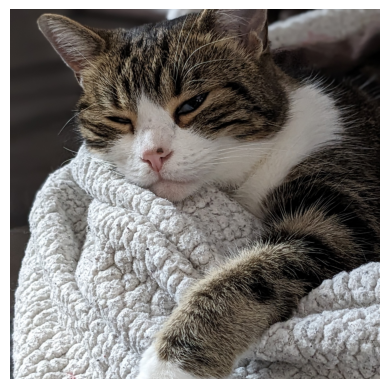

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


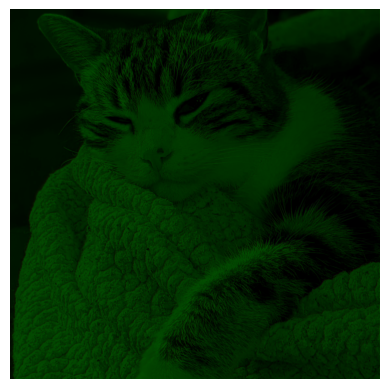

In [5]:
### automatic differentiation with autograd: requires_grad ###

t = torch.from_numpy(np.array(Image.open('notebook-images/cat.jpg'))).permute(2, 0, 1).float() / 255
                                                        # Load the image, permute the dimensions to match the PyTorch format, convert to float and bring the pixel values to the range [0, 1]
plt.imshow(t.permute(1, 2, 0))
                                                        # When displaying the image, we need to reorder the dimensions back to the original order
plt.axis('off')
plt.show()

# Note that there is no fourth dimension for batch-size. This is also fine, but is not the case in practice.

conv = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, padding = 1, bias = False)
                                                        # Create a convolution layer with 3 input and output channels, a kernel size of 3x3 and padding of 1

conv = conv.to(get_device())                            # Move the convolution layer to the device
t = t.to(get_device())                                  # Move the image to the device

t_conv = conv(t)
                                                        # Convolution layers are meant to be used in networks which are trained, so they require gradients by default

try:
                                                        # This will not work a) if the device is not set to 'cpu' and b) if the tensor is still on the computation graph, i.e. requires_grad = True (wich is the case after performing the convolution)
    plt.imshow(t_conv.permute(1, 2, 0))

except TypeError as e:
                                                        # Will occur first if the device is not already set to 'cpu'
    print(f'TypeError: {e}')
    
except RuntimeError as e:
                                                        # Will occur if the device is set to 'cpu', so that the first exception is not raised
    print(f'RuntimeError: {e}')

finally:
    plt.imshow(t_conv.permute(1, 2, 0).detach().to('cpu').clip(0, 1))
                                                        # In addition to .detach() and .to('cpu'), we also clip the values to the range [0, 1] to avoid a warning.
    plt.axis('off')
    plt.show()

### **2 Building Neural Networks in `PyTorch`**

#### **2.1 Important Blocks**

##### **2.1.1 [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)**

```python
CLASS torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros', device = None, dtype = None)
```

When building CNNs, the `nn.Conv2d` block is the most important one, which is why I will explain the parameters in finer detail than for the other blocks discussed here.

**Required parameters**

- `in_channels`: The number of channels handed as input to the convolution layer. Dimension 0 of the input for a single input or 1 for batch input. At the first layer, this is usually 3 for an RGB image and 1 for a grayscale image. In later layers, make sure to keep track of the channel number.
- `out_channels`: The number of output channels produced by this convolution layer.
- `kernel_size`: The size of the kernel. If it is a single number, the kernel is square. If a tuple, height and width can be set individually.

**Optional parameters**

- `stride`: How far to move the kernel for each calculation.
- `padding`: How many cells to add padding around the data (0 is off, 1 is usually used for size-maintaining convolution layers).
- `padding_mode`: What to use for padding. One of `zeroes`, `reflect`, `replicate`, or `circular`
- `groups`: Controls the connections between inputs and outputs. The depth of the filters is $\frac{\text{in\_channels}}{\text{out\_channels}}$. At `groups = 1` every input channel contributes to every output channel – the outputs are summed up to form each channel. At `groups = 2`, half of the output channels are made up of half of the input channels, and the other half of the output is made up of the other half of the input. At `groups = in_channels`, each output channel is produced by only one input channel.
- `bias`: Whether to add a learnable bias to each output channel, which would be summed with the result of the convolution.
- `dilation`: How to "spread" out the targets of the kernels, as visualized [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md).
- `device`: Whether the convolution layer is hardware accelerated, same as with the tensors. The layer must always be on the same device as the input tensors.
- `dtype`: Datatype of the input.

##### **2.1.2 [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)**

<image src="notebook-images/pytorch-relu.png" style="width : 400px">

```python
CLASS torch.nn.ReLU(inplace=False)
```

The nonlinearity as seen above. The layer is simply used as `nn.ReLU()` without parameters.

##### **2.1.3 Pooling Options**

As discussed in the lecture, there are multiple options for pooling layers. An exhaustive list can be found [here](https://pytorch.org/docs/stable/nn.html#pooling-layers) but I listed the ones mentioned in the lecture here:

- **[`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)**
- **[`AvgPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d)**
- **[`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)**

```python
CLASS torch.nn.MaxPool2d(kernel_size, stride = None, padding = 0, dilation = 1, return_indixes = False, ceil_mode = False)
```

```python
CLASS torch.nn.AvgPool2d(kernel_size, stride = None, padding = 0, ceil_mode = False, count_include_pad = True, divisor_override = None)
```

With these blocks it is sufficient to set the `kernel_size`, as the stride is per default set equal to the kernel size. Note that the height and width of your input will be divided by the kernel size, so a kernel size of 2 will lead to a image half the size, a kernel size of 3 to a third the size, and so on.

As discussed in the lecture, `nn.Conv2d` can be used to reduce the height and width of the data when setting stride to a number greater than 1.

##### **2.1.4 [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)**

```python
CLASS torch.nn.Flatten(start_dim=1, end_dim=-1)
```

Does not require any parameters. By setting `start_dim` and `end_dim`, dimensions of the data can be excluded from flattening.

##### **2.1.5 [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)**

```python
CLASS torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
```

A single layer of a fully connected network. `in_features` and `out_features` functions similar to `in_channels` and `out_channels` of the convolution layers, but note that at this point, the data is _flattened_.

##### **2.1.6 [`Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)**

```python
CLASS torch.nn.Softmax(dim=None)
```

Applies the Softmax function to an n-dimensional input Tensor. Rescales them so that the elements of the n-dimensional Tensor lie in the range `[0,1]` and sum to 1.

#### **2.2 Creating a Network**

<image src="notebook-images/cnn.png" style="width : 800px">

**Exercise:** Create the neural network depicted above using existing ``PyTorch`` layers! The first convolution layer should have 8 output channels, the second convolution layer should have 16 output channels. Reduce the scale of the images by half in each pooling layer, picking an option of your choice.

The network will be used on the ``Cifar10`` dataset, which consists of images of the resolution ``32x32`` and has 10 classes. These numbers are relevant when designing the fully connected network.

In [6]:
class CNN(nn.Module):
    '''
    The CNN depicted above, using downsampling convolutions for pooling.
    '''

    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(16 * 8 * 8, 10, bias = False),
            nn.Softmax(dim = -1)
        )


    def forward(self, x):
        return self.network(x)

#### **2.3 For Completeness' Sake: Training and Evaluating the Network**
_Simple training setup shown [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), we will cover this in more detail next week_

In [7]:
### data loading ###

make_tensor = torchvision.transforms.ToTensor()         # This callable object converts a PIL image to a PyTorch tensor

train_data = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = make_tensor)
test_data = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = make_tensor)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 8, shuffle = True)
test_laoder = torch.utils.data.DataLoader(test_data, batch_size = 8, shuffle = False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### initialize model, move to device ###

model = CNN()
model.to(get_device())


### loss function and optimizer ###

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
                                                        # Stochastic Gradient Descent with a learning rate of 0.001 and a momentum of 0.9


### training loop ###

print('Starting Training')
model.train()

for epoch in range(10):                                 # Limit to 10 epochs to keep the runtime short

    sum_loss = 0.0

    for idx, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(get_device()), data[1].to(get_device())

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        if idx % 1000 == 999:
            print(f'Epoch {epoch + 1}, batch {idx + 1}: loss {sum_loss / 1000:.3f}')
            sum_loss = 0.0

print('Finished Training')


### save the model ###

model.eval()
torch.save(model.state_dict(), 'cifar10_cnn.pth')


100.0%


Starting Training
Epoch 1, batch 1000: loss 2.302
Epoch 1, batch 2000: loss 2.299
Epoch 1, batch 3000: loss 2.287
Epoch 1, batch 4000: loss 2.252
Epoch 1, batch 5000: loss 2.206
Epoch 1, batch 6000: loss 2.192
Epoch 2, batch 1000: loss 2.178
Epoch 2, batch 2000: loss 2.163
Epoch 2, batch 3000: loss 2.155
Epoch 2, batch 4000: loss 2.149
Epoch 2, batch 5000: loss 2.138
Epoch 2, batch 6000: loss 2.145
Epoch 3, batch 1000: loss 2.133
Epoch 3, batch 2000: loss 2.132
Epoch 3, batch 3000: loss 2.120
Epoch 3, batch 4000: loss 2.134
Epoch 3, batch 5000: loss 2.126
Epoch 3, batch 6000: loss 2.118
Epoch 4, batch 1000: loss 2.118
Epoch 4, batch 2000: loss 2.109
Epoch 4, batch 3000: loss 2.116
Epoch 4, batch 4000: loss 2.111
Epoch 4, batch 5000: loss 2.113
Epoch 4, batch 6000: loss 2.100
Epoch 5, batch 1000: loss 2.096
Epoch 5, batch 2000: loss 2.092
Epoch 5, batch 3000: loss 2.100
Epoch 5, batch 4000: loss 2.094
Epoch 5, batch 5000: loss 2.095
Epoch 5, batch 6000: loss 2.083
Epoch 6, batch 1000: l

In [8]:
### load the model ###

model = CNN()
model.load_state_dict(torch.load('cifar10_cnn.pth', weights_only = True))
model.to(get_device())


### evaluate ###

correct = 0
total = 0

with torch.no_grad():
    for data in test_laoder:
        images, labels = data[0].to(get_device()), data[1].to(get_device())
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {correct / total:.2f}')

Test Accuracy: 0.46


**Important: There are many tweaks that can be done to the trainnig process or network that increase performance. Also note that training for only 10 epochs can be a factor reducing model performance.**

### **3 Parameter Analysis**

The number of parameters is important for network expressivity on the one hand (a network with more parameters is theoretically capable of expressing a more detailed function), but also network efficiency on the other hand (a network with more parameters usually has a higher computational cost, see below).

#### **3.1 Counting Parameters in ``PyTorch`` Models**

**Exercise:** Calling the ``.parameters()`` method on your model object returns an iteratable for the parameters of your network layers. Looking at the ``shape`` of each of the weight objects allows you to calculate how many parameters are in each layer (by multiplying the sizes of each dimension with each other). Sum up the number of parameters in each layer to get the number of parameters for the entire network. Use this to calculate the number of parameters for your network.

In [9]:
def n_params(model: nn.Module) -> int:
    params: int = 0
    for weight in model.parameters():
        params += torch.prod(torch.tensor(weight.shape)).item() # pyright: ignore[reportAssignmentType]
    return params

for layer_weight in model.parameters():
    print(layer_weight.shape)
print(f'Total number of parameters: {n_params(model)}')

torch.Size([8, 3, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([10, 1024])
Total number of parameters: 11608


#### **3.2 Parameter Counts of Common Layers**

**Exercise:** Let's look at parameter counts of common layer types. In the following cell, there are three common (sub) layers as they are used in popular network architectures. Use the same procedure as above to calculate the number of parameters per layer!

**Note:** Do not directly compare these values! The three shown layers serve completely different purposes and deal with different input configurations.

In [10]:
fully_connected_layer = nn.Linear(in_features = 2048, out_features = 1000)
# ResNet50v1.5's classification head for ImageNet with 1000 classes (He et al., 2016)

resnet_bottleneck = Bottleneck(inplanes = 512, planes = 512)
# as part of ResNet50v1.5's final convolution (super)layer (He et al., 2016)

multihead_attention_layer = nn.MultiheadAttention(embed_dim = 512, num_heads = 8)
# A Multi-Head Attention layer as seen in the original transformer presented in Attention is All You Need (Vaswani et al., 2017)

In [11]:
print(
    f"Fully Connected Layer: \t\t{n_params(fully_connected_layer):,d} parameters.",
    f"ResNet Convolution Layer: \t{n_params(resnet_bottleneck):,d} parameters.",
    f"Multi-Head Attention Layer: \t{n_params(multihead_attention_layer):,} parameters.",
    sep = "\n"
)

Fully Connected Layer: 		2,049,000 parameters.
ResNet Convolution Layer: 	3,676,160 parameters.
Multi-Head Attention Layer: 	1,050,624 parameters.


#### **3.3 Calculating Parameter Counts by Hand**

**Exercise:** Calculate the number of parameters for the following model by hand:

<ul>
    <li><tt>Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)</tt></li>
    <li><tt>ReLU()</tt></li>
    <li><tt>MaxPool2d(2)</tt></li>
    <li><tt>Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)</tt></li>
    <li><tt>ReLU()</tt></li>
    <li><tt>MaxPool2d</tt></li>
    <li><tt>Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)</tt></li>
    <li><tt>ReLU()</tt></li>
    <li><tt>MaxPool2d</tt></li>
    <li><tt>Flatten()</tt></li>
    <li><tt>Linear(in_features = 1024, out_features = 512)</tt></li>
    <li><tt>ReLU()</tt></li>
    <li><tt>Linear(in_features = 512, out_features = 256)</tt></li>
    <li><tt>ReLU()</tt></li>
    <li><tt>Linear(in_features = 256, out_features = 128)</tt></li>
    <li><tt>ReLU()</tt></li>
    <li><tt>Linear(in_features = 128, out_features = 10)</tt></li>
    <li><tt>Softmax(dim = 1)</tt></li>
</ul>

All layers above have the bias disabled, where applicable.

$[16\cdot3\cdot3\cdot3] + [32 \cdot 16 \cdot 3 \cdot 3] + [64 \cdot 32 \cdot 3 \cdot 3] + [512 \cdot 1024] + [256 \cdot 512] + [128 \cdot 256] + [10 \cdot 128] = 712880$

#### **Some Final Remarks on Parameter Counts**

The number of parameters in a model often serve as a heuristic of the model's complexity, but it doesn't tell the whole story. The number of parameters affects at least two things directly:

1. The model's size, which is relevant for storing the model on the hard drive and also for GPU off-loading, as the model's weights need to fit next to the inputs in the GPU's VRAM for accelerated computation
2. The _degrees of freedom_ in optimization, i.e. how much data is needed to optimize the model and how likely the model is to overfit the data.

Models with more parameters also tend to be more computationally expensive, but it is also important _how_ the parameters are used: In a fully connected layer, each parameter (in this case weight) is used _once_, so the number of parameters directly relates to the complexity of the model function. However, a convolution layer might have much less parameters, but be more computationally expensive when applied to large input matrices, as the same set of parameters is repeatedly used when moving the kernel across the image. For attention layers, the number of parameters depends only on the embedding dimension, but the computational complexity scales quadratically with _context length_ as pairwise query-key scores are calculated.

### **Bibliography**

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., Killeen, T., Lin, Z., Gimelshein, N., Antiga, L., Desmaison, A., Köpf, A., Yang, E., DeVito, Z., Raison, M., Tejani, A., Chilamkurthy, S., Steiner, B., Fang, L., … Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library (No. arXiv:1912.01703). arXiv. https://doi.org/10.48550/arXiv.1912.01703

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. 770–778. https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł. ukasz, & Polosukhin, I. (2017). Attention is All you Need. Advances in Neural Information Processing Systems, 30. https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html
